<a href="https://colab.research.google.com/github/compartia/creative/blob/master/NLP_Semantic_Colouring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://www.github.com/nemoware/analyser.git@structure-detector
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.5MB 4.6MB/s 
     |████████████████████████████████| 110.5MB 78kB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 3.8MB 50.2MB/s 
     |████████████████████████████████| 512kB 45.2MB/s 
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [0]:

from tf_support.embedder_elmo import ElmoEmbedder
from tensorflow_docs import plots
from analyser.documents import TextMap
from colab_support.renderer import *

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.core.display import display, HTML
import PIL.Image

import numpy as np
import pandas as pd

import requests

from sklearn.cluster import * 

### Get a text and embedd it using ELMO

In [3]:
sometexturl = 'https://raw.githubusercontent.com/compartia/Zeitsinn/master/zeitsinnism.md'
text = requests.get(sometexturl).text
text[:100]

'![](/zeit/zeitsinn2.jpg)\n\n# Цайтзиннизм\n**Цайтзиннизм** (или цайтсиннизм, от нем. Zeitsinn, буквальн'

In [4]:
## init/load Elmo embedder
elmo = ElmoEmbedder.get_instance('elmo')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
# tokenize text
tm = TextMap (text)
print('number of tokens:', len(tm))

embedding = elmo.embedd_tokens(tm.tokens)

number of tokens: 2763


### Look at the embeddings

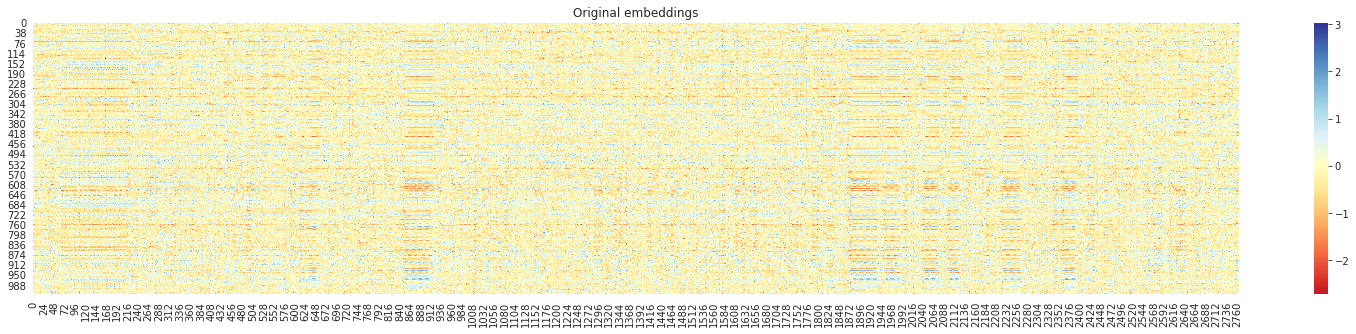

In [29]:
plotter = plots.HistoryPlotter(smoothing_std=2)

def plot_emb(matrix, title=None):    
  mt = matrix.T  
  with sns.axes_style("white"):
    plt.figure(figsize=(27, 5))
    ax = sns.heatmap(mt, square=False,  cmap="RdYlBu", center=0)
    if title:
      plt.title(title)
    plt.show()

def render_spectrum(x, h=100):   
  arr = (255 * ((x+1.0)*0.5).reshape((1,-1, 3))).astype(np.uint8)
  img = PIL.Image.fromarray(arr, 'RGB')
  img = img.resize( (1400,h), resample=PIL.Image.BICUBIC )
  display(img)



def render_token_colors(tokens, tcolors ) -> str:
  html = ''
  separator = ' '
  tcolors_scaled = ( tcolors + 1.0 ) * 0.5
  for d, word in enumerate(tokens):

    if word == ' ':
      word = '&nbsp;_ '
    
    token_color = colors.to_hex( tcolors_scaled[d] )
 
    html += f'<span style="background-color:{token_color}">_{word}{separator}</span>'

    if tokens[d] == '\n':
      html += "¶<br>"

  return html

plot_emb(embedding, title='Original embeddings')

#### Embeddings, sorted by mean

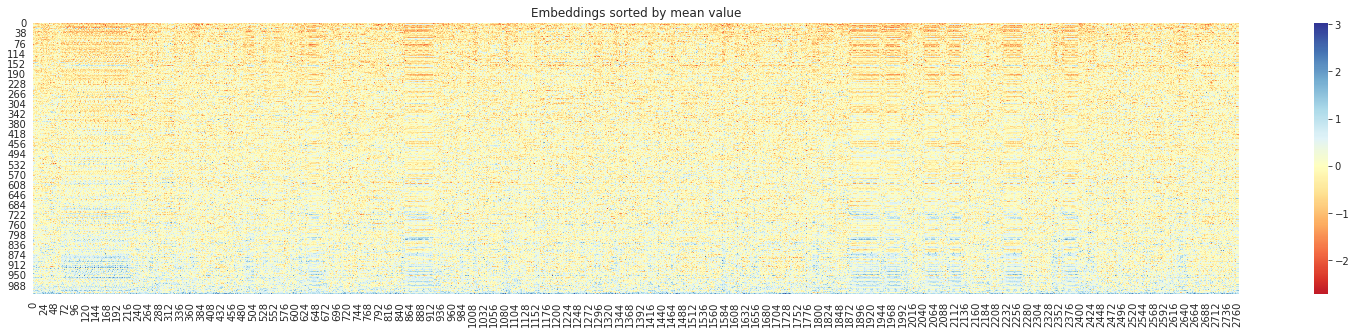

In [19]:
b = np.mean(embedding, axis =-2)
idx = b.argsort()
plot_emb(np.take(embedding, idx, axis=-1), title='Embeddings sorted by mean value')

## Autoencoder (bottleneck) model

In [37]:
 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

def build_enc_model():
  EMB=1024
  model = keras.Sequential()
  
  #downscale  
  model.add(layers.Dense(32, activation='tanh', input_shape=[EMB]  ))
  model.add(layers.Dropout(rate=0.5, seed=42))
  model.add(layers.Dense(16, activation='tanh'))

  #this is it
  model.add(layers.Dense(3, activation='tanh', name='bottleneck'))

  ## scale-up
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(EMB, activation='tanh'))


  # optimizer = tf.keras.optimizers.RMSprop(0.001) #TODO try it
  optimizer = 'Nadam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', tf.keras.metrics.CosineSimilarity()])
  return model

model = build_enc_model()
model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                32800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
bottleneck (Dense)           (None, 3)                 51        
_________________________________________________________________
dense_14 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              33792     
Total params: 67,299
Trainable params: 67,299
Non-trainable params: 0
__________________________________________________

### Bottlneck layer  (sub) model

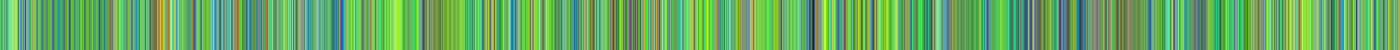

In [38]:
neck_output_model = keras.Model(model.input, model.get_layer(name = 'bottleneck').output )

example_result = neck_output_model.predict(embedding)
p_emb = model.predict(embedding)

render_spectrum(example_result, 50)


In [0]:
history = model.fit( 
    embedding, embedding,
    epochs=1500, validation_split = 0.2, verbose=0 )

Text(0, 0.5, 'MAE [MPG]')

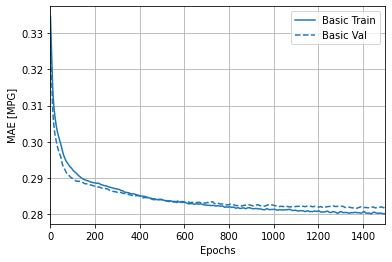

In [40]:
plotter.plot({'Basic': history}, metric = "mean_absolute_error")
plt.ylabel('MAE [MPG]')

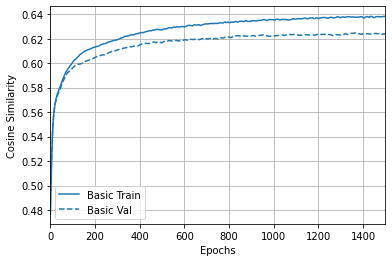

In [41]:
plotter.plot({'Basic': history}, metric = "cosine_similarity")

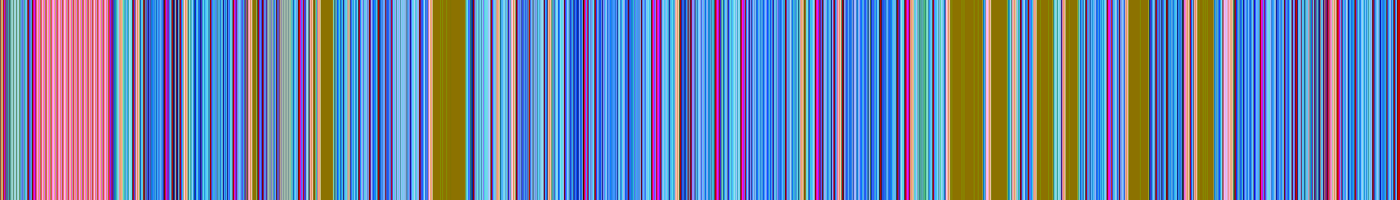

In [42]:
example_result = neck_output_model.predict(embedding)
render_spectrum(example_result, 200)
HTML(  render_token_colors (tm.tokens, example_result) )